# Satisfaction Analysis

In [18]:
import psycopg2
import sqlalchemy
import os
from dotenv import load_dotenv

load_dotenv()

# Print connection details (without password)
print(f"Attempting to connect to:")
print(f"Database: {os.getenv('DB_NAME')}")
print(f"User: {os.getenv('DB_USER')}")
print(f"Host: {os.getenv('DB_HOST')}")
print(f"Port: {os.getenv('DB_PORT')}")

try:
    conn = psycopg2.connect(
        dbname=os.getenv('DB_NAME'),
        user=os.getenv('DB_USER'),
        password=os.getenv('DB_PASSWORD'),
        host=os.getenv('DB_HOST'),
        port=os.getenv('DB_PORT')
    )
    print("Successfully connected to database!")
    conn.close()
except Exception as e:
    print(f"Connection failed: {e}")

Attempting to connect to:
Database: telecom_db
User: postgres
Host: localhost
Port: 5432
Successfully connected to database!


### Load the XDR data with error checking

In [4]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
sys.path.append('../scripts')  # Add scripts folder to Python path
from visualization_utils import plot_histogram, plot_boxplot, plot_heatmap, scatter_pca, plot_pie_chart, plot_bar_chart
from load_data import load_table_to_dataframe # to load the data
# Load the XDR data with error checking
xdr_data = load_table_to_dataframe("xdr_data")
if xdr_data is None:
    print("Failed to load data. Please check:")
    print("1. Database connection settings in .env file")
    print("2. Database is running and accessible")
    print("3. Table 'xdr_data' exists in the database")
else:
    print(xdr_data.head())


/home/bbm/Documents/projects/Telecom-Data-Analysis/notebooks/../scripts/load_data.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

### Engagement and Experience Scores

   MSISDN/Number  Engagement Score  Experience Score
0   3.360100e+10          5.580163          2.251049
1   3.360100e+10          5.576873          2.247075
2   3.360100e+10          5.567696          2.206478
3   3.360101e+10          5.608884          2.204562
4   3.360101e+10          3.435117          1.642967


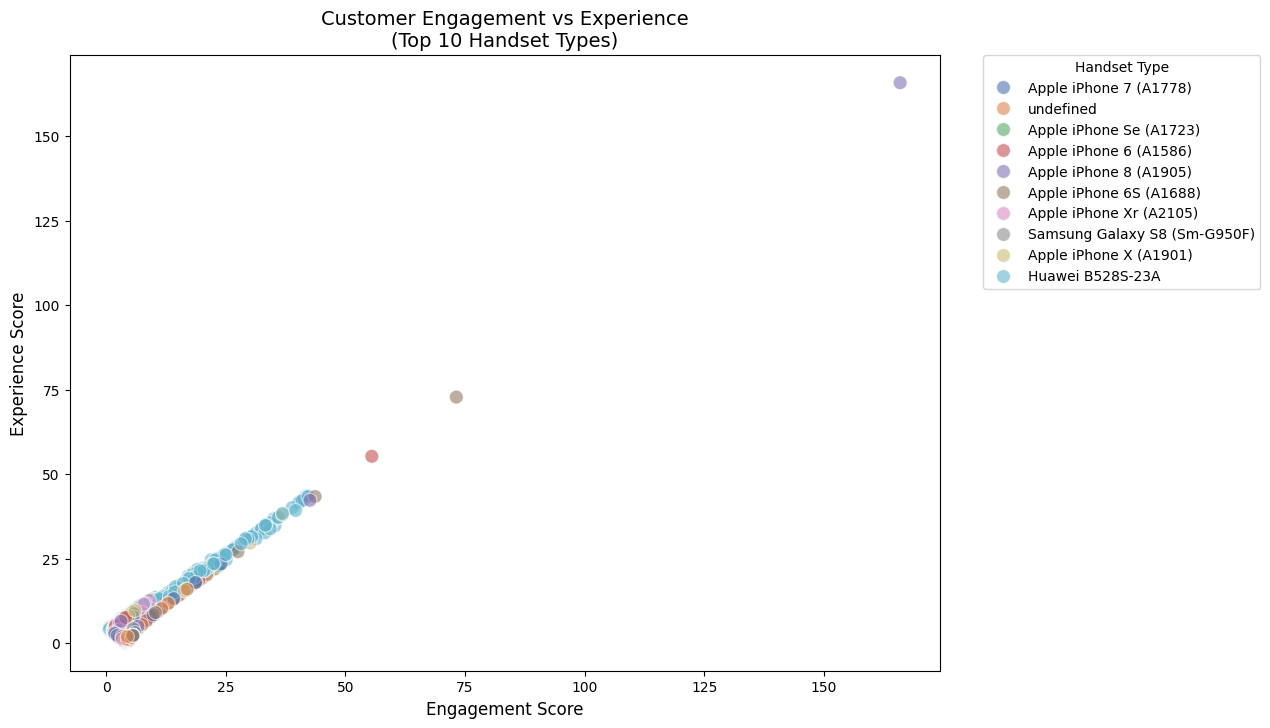

In [11]:
# ... existing code ...

experience_data = xdr_data.groupby('MSISDN/Number').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean',
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean',
    'Handset Type': lambda x: x.mode()[0] if not x.mode().empty else None
}).reset_index()

# Handle missing values
experience_data.fillna(experience_data.mean(numeric_only=True), inplace=True)

# Prepare features using the columns we actually have
features = experience_data[[
    'TCP DL Retrans. Vol (Bytes)',
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)'
]]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Rest of the code remains the same
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(features_scaled)
engagement_centroids = kmeans.cluster_centers_

# Compute Scores
experience_data['Engagement Score'] = cdist(features_scaled, [engagement_centroids[0]]).flatten()
experience_data['Experience Score'] = cdist(features_scaled, [engagement_centroids[2]]).flatten()

print(experience_data[['MSISDN/Number', 'Engagement Score', 'Experience Score']].head())

# Visualization
# Get top 10 most common handset types
top_handsets = xdr_data['Handset Type'].value_counts().nlargest(10).index
filtered_data = experience_data[experience_data['Handset Type'].isin(top_handsets)]

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=filtered_data,
    x='Engagement Score',
    y='Experience Score',
    hue='Handset Type',
    palette='deep',
    alpha=0.6,
    s=100
)

plt.title('Customer Engagement vs Experience\n(Top 10 Handset Types)', fontsize=14)
plt.xlabel('Engagement Score', fontsize=12)
plt.ylabel('Experience Score', fontsize=12)

# Move legend outside the plot
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0,
    title='Handset Type'
)

# Adjust layout
plt.subplots_adjust(right=0.85)  # Make room for legend
plt.show()


### Satisfaction Score


        MSISDN/Number  Satisfaction Score
47983    3.366232e+10          165.883300
80249    3.368369e+10           93.876824
37287    3.365978e+10           92.742881
17134    3.363330e+10           72.985632
94139    3.376109e+10           70.556831
69218    3.366850e+10           60.843167
41944    3.366087e+10           55.389671
18351    3.363637e+10           52.296301
103348   3.377808e+10           50.988689
93844    3.376094e+10           46.349642


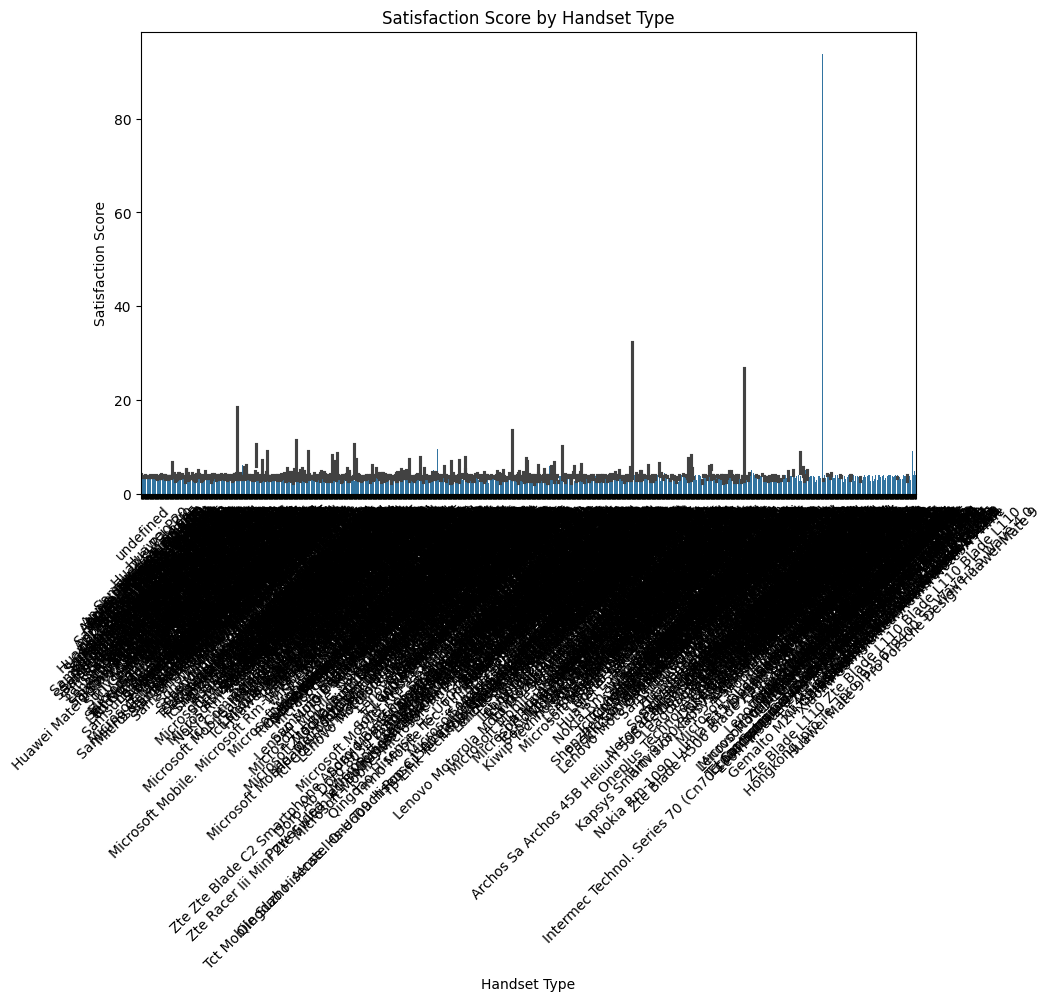

In [13]:
# Satisfaction Score as average of Engagement and Experience Scores
experience_data['Satisfaction Score'] = (experience_data['Engagement Score'] + experience_data['Experience Score']) / 2

# Top 10 Satisfied Customers
top_satisfied = experience_data.nlargest(10, 'Satisfaction Score')
print(top_satisfied[['MSISDN/Number', 'Satisfaction Score']])

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Handset Type', y='Satisfaction Score', data=experience_data)
plt.title('Satisfaction Score by Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Satisfaction Score')
plt.xticks(rotation=45)
plt.show()


### Predict Satisfaction Score


In [14]:
# Splitting data
X = experience_data[['Engagement Score', 'Experience Score']]
y = experience_data['Satisfaction Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")

Mean Squared Error: 7.768740729652321e-31
R2 Score: 1.0


### K-means clustering on engagement & experience scores

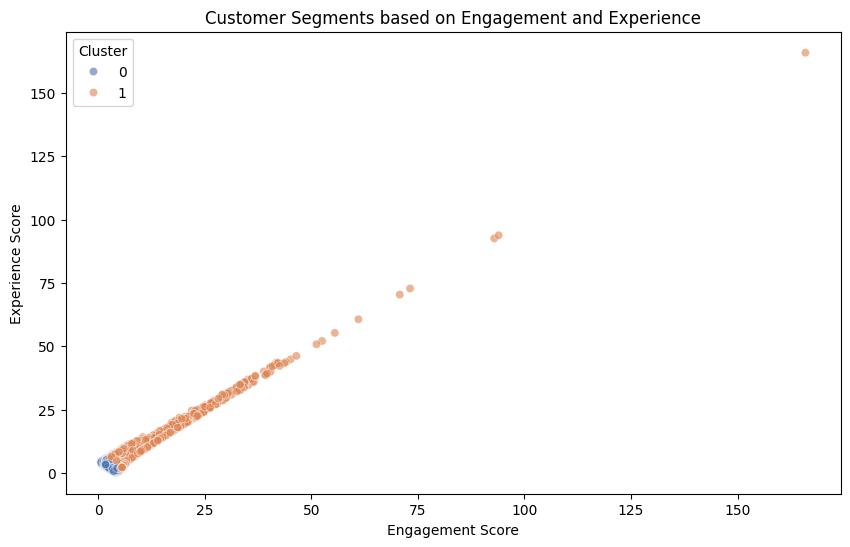

In [15]:
X_cluster = experience_data[['Engagement Score', 'Experience Score']]
kmeans_final = KMeans(n_clusters=2, random_state=42)
experience_data['Cluster'] = kmeans_final.fit_predict(X_cluster)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=experience_data,
    x='Engagement Score',
    y='Experience Score',
    hue='Cluster',
    palette='deep',
    alpha=0.6
)
plt.title('Customer Segments based on Engagement and Experience')
plt.show()

### Aggregate scores per cluster

In [16]:
cluster_summary = experience_data.groupby('Cluster').agg({
    'Satisfaction Score': 'mean',
    'Experience Score': 'mean',
    'Engagement Score': 'mean',
    'MSISDN/Number': 'count'  # Count of customers in each cluster
}).round(2)

print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
         Satisfaction Score  Experience Score  Engagement Score  MSISDN/Number
Cluster                                                                       
0                      2.81              1.41              4.22          29369
1                      4.02              2.40              5.64          77487


### Export to database

In [20]:
# First, prepare the final table
final_table = experience_data[['MSISDN/Number', 'Engagement Score', 
                             'Experience Score', 'Satisfaction Score', 'Cluster']]

# Create SQLAlchemy engine for better pandas integration
from sqlalchemy import create_engine

# Create database connection string
db_params = {
    'host': os.getenv('DB_HOST'),
    'database': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'port': os.getenv('DB_PORT')
}

# Create SQLAlchemy engine
engine = create_engine(f"postgresql://{db_params['user']}:{db_params['password']}@"
                      f"{db_params['host']}:{db_params['port']}/{db_params['database']}")

# Export to database
table_name = 'customer_satisfaction_scores'
final_table.to_sql(table_name, engine, if_exists='replace', index=False)

# Verify the export with a select query
verification_query = f"""
SELECT *
FROM {table_name}
LIMIT 5;
"""

# Execute and display the verification query
print("\nVerification Query Result:")
result_df = pd.read_sql(verification_query, engine)
print(result_df)

# Close the database connection
engine.dispose()


Verification Query Result:
   MSISDN/Number  Engagement Score  Experience Score  Satisfaction Score  \
0   3.360100e+10          5.580163          2.251049            3.915606   
1   3.360100e+10          5.576873          2.247075            3.911974   
2   3.360100e+10          5.567696          2.206478            3.887087   
3   3.360101e+10          5.608884          2.204562            3.906723   
4   3.360101e+10          3.435117          1.642967            2.539042   

   Cluster  
0        1  
1        1  
2        1  
3        1  
4        0  
